# CS3891 Final Project
## Quantum Markov Chains for European Options Pricing
### This file will contain an example code to implement a simple Markov Chain in QISKIT
### Resources
https://quantumcomputing.stackexchange.com/questions/22235/very-simple-matrix-operation-markov-chain-in-terms-of-qiskit
https://en.wikipedia.org/wiki/Markov_chain
https://medium.com/qiskit/studying-quantum-walks-on-near-term-quantum-computers-f60fd2395f04
https://www.ibm.com/quantum/blog/quantum-markov-chain-monte-carlo

The following code is a simple example of a conventional Markov Chain of the form:

$$
v_{0}=\begin{pmatrix}
1 & 0 & 0
\end{pmatrix}
\\\\
M=\begin{pmatrix}
0 & 0.2 & 0.8\\ 
0.5 & 0 & 0.5\\ 
0.1 & 0.9 & 0
\end{pmatrix}
\\\\
v_{1}=v_{0}M
\\\\
v_{3}=v_{0}M^{3}
$$

In [1]:
import numpy as np
M = np.array([[0, 0.2, 0.8], [0.5, 0, 0.5], [0.1, 0.9, 0]])
v0=np.array([1,0,0])
v1=v0.dot(M)
print(v1)
v2=v0.dot(np.linalg.matrix_power(M, 2))
print(v2)
v3=v0.dot(np.linalg.matrix_power(M, 3))
print(v3)

[0.  0.2 0.8]
[0.18 0.72 0.1 ]
[0.37  0.126 0.504]


This is it's QISKIT instantiation

In [2]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from numpy import pi

# Inilialise registers
qreg_q = QuantumRegister(6, 'q')
creg_c = ClassicalRegister(3, 'c')

# Create Markov Step as a circuit
markov_step = QuantumCircuit(qreg_q)

# Create the Markov Step
# From state 0 to state 1 and 2
markov_step.crx(2*np.arccos(np.sqrt(M[0,1])), qreg_q[0], qreg_q[4], label="CRX")
markov_step.ccx(qreg_q[4], qreg_q[0], qreg_q[5])
markov_step.cx(qreg_q[0], qreg_q[4])

# From state 1 to state 0 and 2
markov_step.crx(2*np.arccos(np.sqrt(M[1,2])), qreg_q[1], qreg_q[5], label="CRX")

markov_step.ccx(qreg_q[5], qreg_q[1], qreg_q[3])
markov_step.cx(qreg_q[1], qreg_q[5])

# From state 2 to state 0 and 1
markov_step.crx(2*np.arccos(np.sqrt(M[2,0])), qreg_q[2], qreg_q[3], label='CRX')
markov_step.ccx(qreg_q[3], qreg_q[2], qreg_q[4])
markov_step.cx(qreg_q[2], qreg_q[3])

# Swap
markov_step.swap(qreg_q[0], qreg_q[3])
markov_step.swap(qreg_q[1], qreg_q[4])
markov_step.swap(qreg_q[2], qreg_q[5])

# Initialise circuit
circuit = QuantumCircuit(qreg_q,creg_c)

# Initialise state (1,0,0)
circuit.x(0)

# Do the markov step n times
n = 3
for _ in range(n):
    for ins in markov_step:
        circuit.append(ins[0], ins[1], ins[2])
    circuit.reset(qreg_q[3:])

# Measure outcome
circuit.measure(qreg_q[:3], creg_c)

Draw the Quantum Circuit

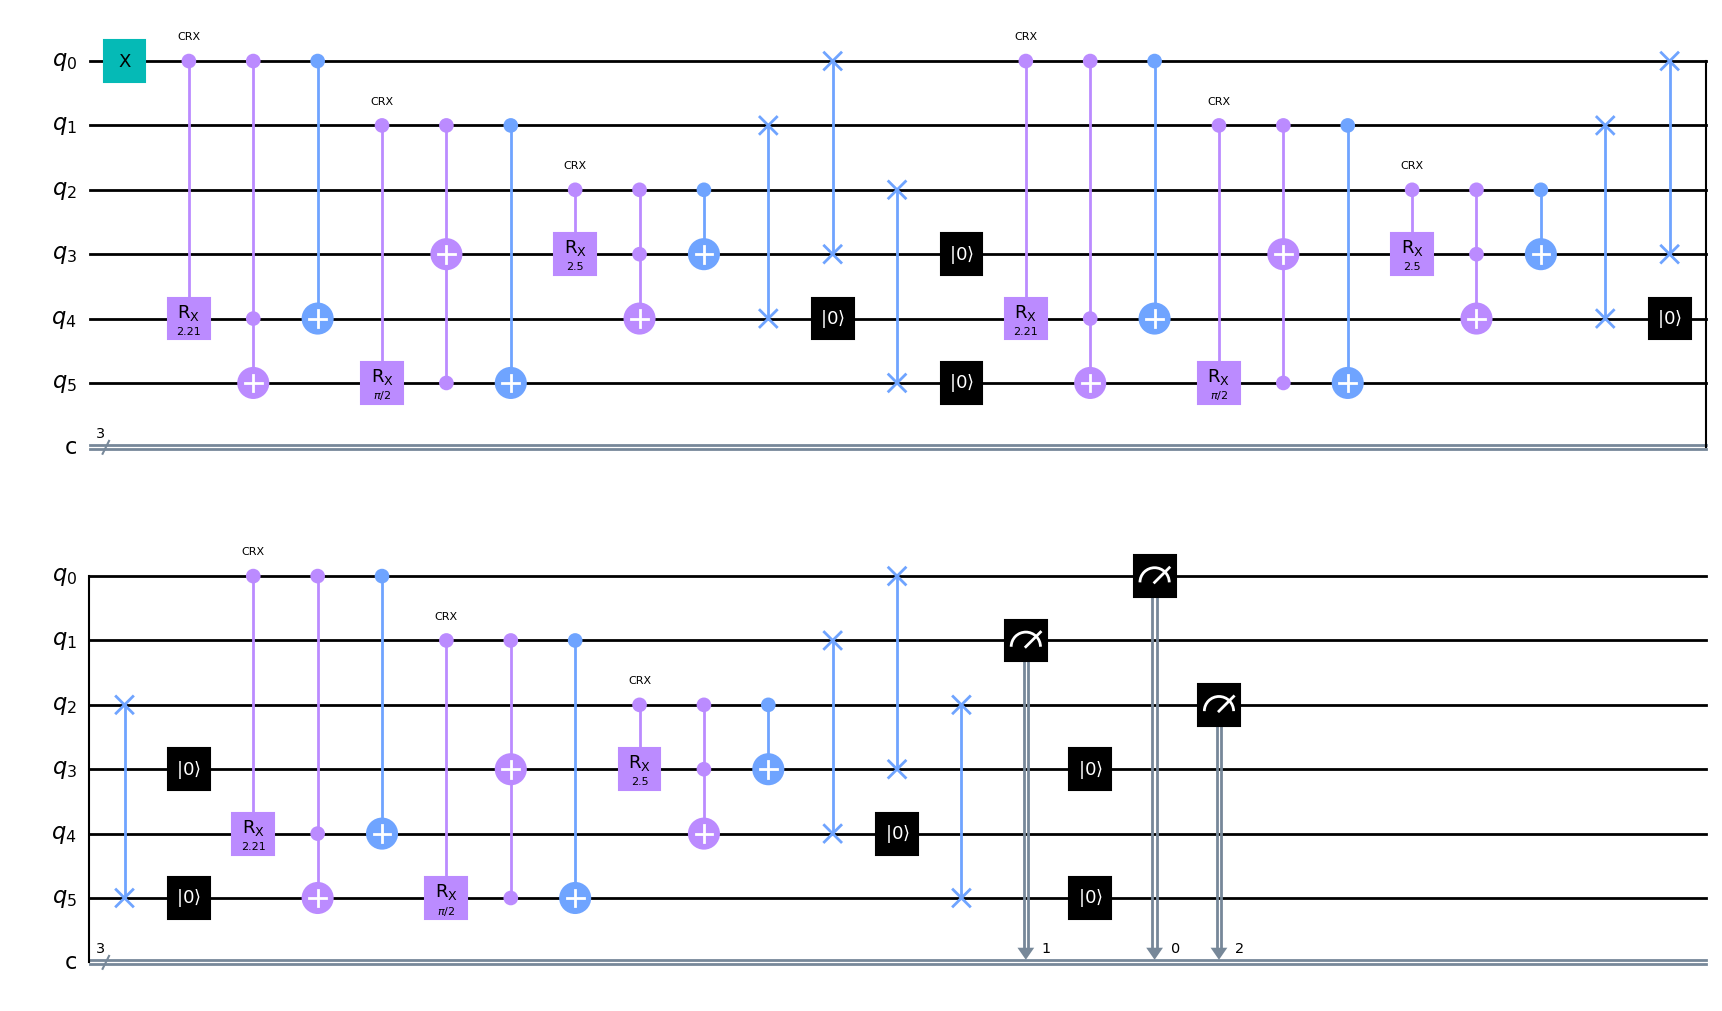

In [3]:
# Draw the circuit
circuit.draw(output='mpl')

Simulate the Quantum Circuit

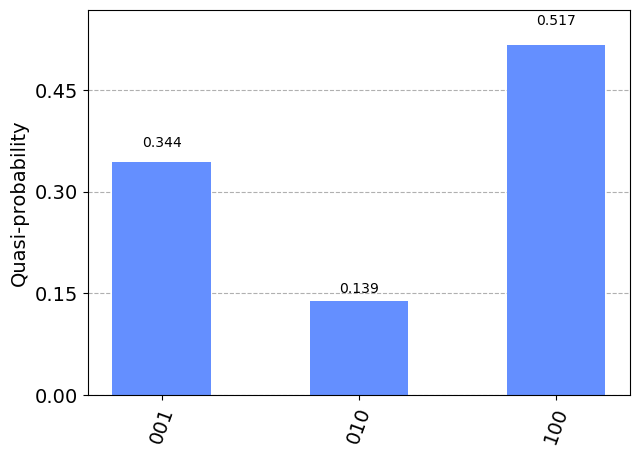

In [6]:
from qiskit import Aer, transpile
from qiskit.visualization import plot_histogram

# Define the Aer simulator backend
simulator_backend = Aer.get_backend('qasm_simulator')

# Transpile the circuit for the simulator backend
transpiled_circuit = transpile(circuit, simulator_backend)

# Run the circuit on the simulator backend
job = simulator_backend.run(transpiled_circuit, shots=1000)

# Get the result of the simulation
result = job.result()

# Get the counts of the measurement outcomes
counts = result.get_counts()

# Normalize the counts to probabilities
total_shots = sum(counts.values())
probabilities = {state: count / total_shots for state, count in counts.items()}

# Plot the histogram
plot_histogram(probabilities)